# Лабораторна робота №1
Тема: Підготовка статистичних даних: читання, описова статистика, очистка  
Студент: Луцюк Богдан КН-2  
Варіант: 4  
Дата: 06.10.2025  
Репозиторій: https://github.com/emissuu/UniTasks/tree/main/R/Lab1

## Parameters

In [ ]:
library(tidyverse)
library(lubridate)

# Basics
seed <- 16

# Data generation
n <- 500
data_gen <- list(
  number_customers = 4000,
  number_couriers = 200
)

# Dirt multipliers
dirt_gen <- list(
  assigned_at_loss = 0.10,
  picked_at_loss = 0.08,
  delivered_at_loss = 0.06,
  note_loss = 0.06,

  duplicates = 0.02,
  almost_duplicates = 0.015,

  other_date_format = 0.12,
  coma_in_numerics = 0.1,

  negative_delivery_fee = 0.05,
  amplified_distance = 0.007,
  time_anomalies = 0.01,
  canceled_delivered = 0.005,
  confused_lat_lon = 0.015,

  invalid_text = 0.02
)

: [1m[33mError[39m in `library()`:[22m
[33m![39m there is no package called ‘stringdist’

## Section 1

### Генеруємо дані

In [82]:
set.seed(seed)

order_id       <- 1:n
created_at     <- as.POSIXct(
  runif(n, 
    as.numeric(c.POSIXct("2024-04-01 00:00:00")), 
    as.numeric(c.POSIXct("2024-04-30 23:59:59"))
  ),
origin = "1970-01-01", tz = "Europe/Kyiv"
)
status <- sample(c("created", "assigned", "picked", "delivered", "canceled"), n, TRUE)
assigned_at <- if_else(
  status %in% c("assigned", "picked", "delivered") | status == "canceled" & runif(n) < 0.66,
  created_at + sample(10:60, n, TRUE) * 60,
  NA
)
picked_at <- if_else(
  status %in% c("picked", "delivered") | status == "canceled" & is.na(assigned_at) & runif(n) < 0.50,
  assigned_at + sample(10:60, n, TRUE) * 60,
  NA
)
delivered_at <- if_else(
  status == "delivered",
  picked_at + sample(10:60, n, TRUE) * 60,
  NA
)
customer_id <- sample(1:data_gen[["number_customers"]], n, TRUE)
city <- sample(c("Kyiv", "Lviv", "Odesa"), n, TRUE)
lat <- if_else(city == "Kyiv", round(runif(n, 50.259976, 50.555627), 6), 
  if_else(city == "Lviv", round(runif(n, 49.767958, 49.885124), 6),
  if_else(city == "Odesa", round(runif(n, 46.320902, 46.560871), 6),
  NA
)))
lon <- if_else(city == "Kyiv", round(runif(n, 30.282074, 30.759165), 6), 
  if_else(city == "Lviv", round(runif(n, 23.909936, 24.117936), 6),
  if_else(city == "Odesa", round(runif(n, 30.615875, 30.772156), 6),
  NA
)))
distance_km <- round(runif(n, 0.2, 26), 2)
service_level <- sample(c("Standart", "Express"), n, TRUE)
payment_method <- sample(c("Card", "COD"), n, TRUE)
items_count <- sample(1:6, n, TRUE)
order_value <- sample(100:6000, n, TRUE)
delivery_fee <- if_else(service_level == "Standart", 40 + distance_km * 2, 60 + distance_km * 3)
courier_id <- sample(1:data_gen[["number_couriers"]], n, TRUE)
note <- sample(c("fragile", "liquid", "sharp", "perishable", NA, NA, NA, NA), n, TRUE)

data <- data.frame(
  order_id         = order_id,
  created_at       = created_at,
  assigned_at      = assigned_at,
  picked_at        = picked_at,
  delivered_at     = delivered_at,
  status           = status,
  customer_id      = customer_id,
  city             = city,
  lat              = lat,
  lon              = lon,
  distance_km      = distance_km,
  service_level    = service_level,
  payment_method   = payment_method,
  items_count      = items_count,
  order_value      = order_value,
  delivery_fee     = delivery_fee,
  courier_id       = courier_id,
  note             = note,
  stringsAsFactors = FALSE
)

rm(order_id, created_at, assigned_at, picked_at, delivered_at, status, customer_id, city, lat, lon, 
  distance_km, service_level, payment_method, items_count, order_value, delivery_fee, courier_id, note)

glimpse(data)

Rows: 500
Columns: 18
$ order_id       <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, …
$ created_at     <dttm> 2024-04-21 11:50:20, 2024-04-08 07:45:52, 2024-04-14 1…
$ assigned_at    <dttm> 2024-04-21 12:20:20, 2024-04-08 08:40:52, NA, 2024-04-…
$ picked_at      <dttm> 2024-04-21 13:11:20, NA, NA, NA, 2024-04-26 23:02:31, …
$ delivered_at   <dttm> NA, NA, NA, NA, 2024-04-26 23:26:31, NA, NA, NA, NA, N…
$ status         <chr> "picked", "assigned", "canceled", "assigned", "delivere…
$ customer_id    <int> 2106, 3727, 3854, 396, 2217, 672, 3099, 1681, 2207, 231…
$ city           <chr> "Kyiv", "Odesa", "Lviv", "Kyiv", "Kyiv", "Lviv", "Lviv"…
$ lat            <dbl> 50.32855, 46.40073, 49.82669, 50.47731, 50.49614, 49.84…
$ lon            <dbl> 30.47308, 30.64616, 24.08462, 30.35421, 30.45474, 24.04…
$ distance_km    <dbl> 12.91, 4.53, 20.63, 0.70, 7.99, 20.30, 8.98, 15.87, 25.…
$ service_level  <chr> "Standart", "Express", "Standart", "Standart", "Standar…
$ payment_method <

### Забруднюємо їх

In [83]:
set.seed(seed)

# ===== Gaps =====
data <- data |>
  mutate(
    assigned_at = if_else(runif(n) < dirt_gen[["assigned_at_loss"]], NA, assigned_at),
    picked_at = if_else(runif(n) < dirt_gen[["picked_at_loss"]], NA, picked_at),
    delivered_at = if_else(runif(n) < dirt_gen[["delivered_at_loss"]], NA, delivered_at),
    note = if_else(runif(n) < dirt_gen[["note_loss"]], NA, note)
  )

# ===== Duplicates =====
source_rows <- sample(1:n, round(dirt_gen[["duplicates"]] * n), TRUE)
target_rows <- sample(1:n, round(dirt_gen[["duplicates"]] * n), FALSE)
data[target_rows, ] <- data[source_rows, ]
# rm(source_rows, target_rows)

almost_dupl_size <- round(dirt_gen[["almost_duplicates"]] * n)
source_rows <- sample(1:n, almost_dupl_size, TRUE)
target_rows <- sample(1:n, almost_dupl_size, FALSE)
temp_data <- data[source_rows, ]
temp_data <- temp_data |>
  mutate(
    city = if_else(runif(almost_dupl_size) < 0.6, 
      if_else(runif(almost_dupl_size) < 0.6, toupper(city), paste(city, " ")), city),
    service_level = if_else(runif(almost_dupl_size) < 0.7, 
      if_else(runif(almost_dupl_size) < 0.5, toupper(service_level), paste(" ", service_level)), service_level),
    payment_method = if_else(runif(almost_dupl_size) < 0.4, 
      if_else(runif(almost_dupl_size) < 0.5, tolower(payment_method), paste(payment_method, " ")), payment_method)
  )
data[target_rows, ] <- temp_data
rm(almost_dupl_size, source_rows, target_rows, temp_data)

# ===== Anomalies =====
data <- data |>
  mutate(
    delivery_fee = if_else(
      runif(n) < dirt_gen[["negative_delivery_fee"]],
      if_else(runif(n) < 0.5, 0, (delivery_fee * -1)),
      delivery_fee
    ),
    distance_km = if_else(
      runif(n) < dirt_gen[["amplified_distance"]],
      distance_km * 8,
      distance_km
    ),
    delivered_at = if_else(
      runif(n) < dirt_gen[["time_anomalies"]],
      NA,
      delivered_at
    ),
    picked_at = if_else(
      runif(n) < dirt_gen[["time_anomalies"]] / 2,
      NA,
      picked_at
    )
  )
rows_to_affect <- runif(n) < dirt_gen[["confused_lat_lon"]]
for(row in 1:n)
  if(rows_to_affect[row]) {
    temp = data$lat[row]
    data$lat[row] = data$lon[row]
    data$lon[row] = temp
  }
rm(rows_to_affect)

# ===== Types / Formats =====
data <- data |>
  mutate(
    created_at = if_else(
      runif(n) < dirt_gen[["other_date_format"]], 
      format(created_at, "%d.%m.%Y %H:%M"), 
      format(created_at, "%Y-%m-%d %H:%M:%S")),
    assigned_at = if_else(
      runif(n) < dirt_gen[["other_date_format"]], 
      format(assigned_at, "%d.%m.%Y %H:%M"), 
      format(assigned_at, "%Y-%m-%d %H:%M:%S")),
    picked_at = if_else(
      runif(n) < dirt_gen[["other_date_format"]], 
      format(picked_at, "%d.%m.%Y %H:%M"), 
      format(picked_at, "%Y-%m-%d %H:%M:%S")),
    delivered_at = if_else(
      runif(n) < dirt_gen[["other_date_format"]], 
      format(delivered_at, "%d.%m.%Y %H:%M"), 
      format(delivered_at, "%Y-%m-%d %H:%M:%S"))
  )

data <- data |>
  mutate(
    order_value = if_else(
      runif(n) < dirt_gen[["coma_in_numerics"]], 
      order_value |> 
        formatC(format = "f", big.mark = " ", digits = 0) |> 
        as.character(),
      order_value |> as.character()),
    delivery_fee = if_else(
      runif(n) < dirt_gen[["coma_in_numerics"]], 
      sub("\\.", ",", delivery_fee |> 
        formatC(format = "f", big.mark = " ", digits = 2) |> 
        as.character()),
      delivery_fee |> as.character()),
  )

# ===== Text registries =====
data <- data |>
  mutate(
    city = if_else(
      runif(n) < dirt_gen[["invalid_text"]],
      paste(toupper(city), " "),
      city
    ),
    service_level = if_else(
      runif(n) < dirt_gen[["invalid_text"]],
      paste(" ", toupper(service_level)),
      service_level
    ),
    payment_method = if_else(
      runif(n) < dirt_gen[["invalid_text"]],
      paste(tolower(payment_method), " "),
      payment_method
    ),
    note = if_else(
      runif(n) < dirt_gen[["invalid_text"]],
      if_else(is.na(note), " ", paste(" ", note)),
      note
    )
  )

write.csv(data, "..\\raw\\data.csv")

## Section 2
### Описова статистика "до"

New names:
• `` -> `...1`
Rows enumeration:
Rows: 500
Columns: 19
$ ...1           <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, …
$ order_id       <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 105, 11, 12, 13, 14, 15, 16,…
$ created_at     <chr> "21.04.2024 11:50", "2024-04-08 07:45:52", "2024-04-14 …
$ assigned_at    <chr> "2024-04-21 12:20:20", "2024-04-08 08:40:52", NA, "2024…
$ picked_at      <chr> "21.04.2024 13:11", NA, NA, NA, "26.04.2024 23:02", NA,…
$ delivered_at   <chr> NA, NA, NA, NA, "2024-04-26 23:26:31", NA, NA, NA, NA, …
$ status         <chr> "picked", "assigned", "canceled", "assigned", "delivere…
$ customer_id    <dbl> 2106, 3727, 3854, 396, 2217, 672, 3099, 1681, 2207, 205…
$ city           <chr> "Kyiv", "Odesa", "Lviv", "Kyiv", "Kyiv", "Lviv", "Lviv"…
$ lat            <dbl> 50.32855, 46.40073, 49.82669, 50.47731, 50.49614, 49.84…
$ lon            <dbl> 30.47308, 30.64616, 24.08462, 30.35421, 30.45474, 24.04…
$ distance_km    <dbl> 12.91, 4.53, 20.63, 0.70, 7.99,

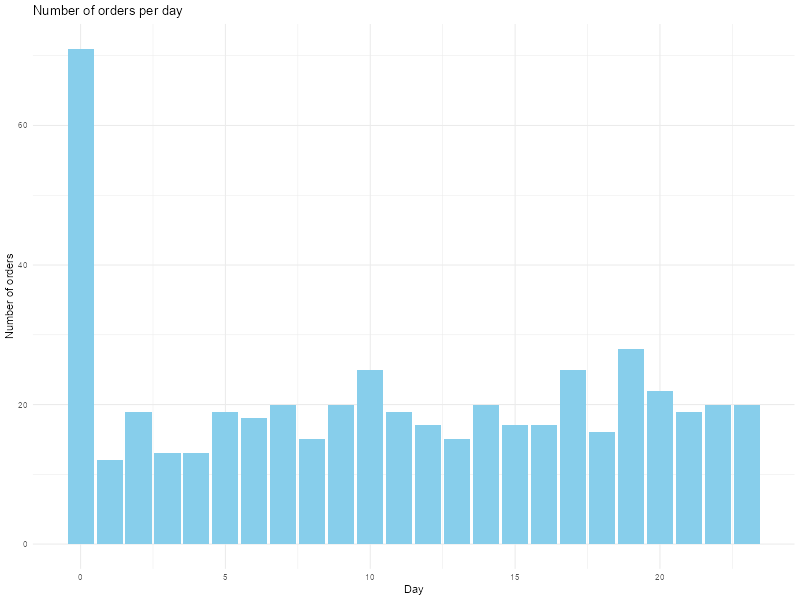

In [ ]:
data_dirty <- read_csv("..\\raw\\data.csv", show_col_types = FALSE)

cat("Rows enumeration:\n")
glimpse(data_dirty)

gaps <- list(
  created_at = sum(is.na(data_dirty$created_at)),
  assigned_at = sum(is.na(data_dirty$assigned_at)),
  picked_at = sum(is.na(data_dirty$picked_at)),
  delivered_at = sum(is.na(data_dirty$delivered_at)),
  note = sum(is.na(data_dirty$note))
)
cat("\nGaps number:\n")
cat("Created_at: ", gaps[["created_at"]], " gaps (", gaps[["created_at"]] / n * 100, "%)\n", sep = "")
cat("Assigned_at: ", gaps[["assigned_at"]], " gaps (", gaps[["assigned_at"]] / n * 100, "%)\n", sep = "")
cat("Picked_at: ", gaps[["picked_at"]], " gaps (", gaps[["picked_at"]] / n * 100, "%)\n", sep = "")
cat("Delivered_at: ", gaps[["delivered_at"]], " gaps (", gaps[["delivered_at"]] / n * 100, "%)\n", sep = "")
cat("Note: ", gaps[["note"]], " gaps (", gaps[["note"]] / n * 100, "%)\n", sep = "")

cat("\nDuplicates:", sum(duplicated(data_dirty)))
cat("\nAlmost duplicates: ", sum(duplicated(data_dirty$order_id)), " (", sum(duplicated(data_dirty$order_id)) / n * 100, "%)\n", sep = "")

cat("\nDelivered without delivery date:", sum(data_dirty$status == 'delivered' & is.na(data_dirty$delivered_at)))
cat("\nDelivered when cancelled:", sum(data_dirty$status == "cancelled" & !is.na(data_dirty$delivered_at)))
cat("\nCoordinates beyong city borders:", sum(
  data_dirty$city == "Kyiv" & (!between(data_dirty$lat, 50.259976, 50.555627) | !between(data_dirty$lon, 30.282074, 30.759165)) |
  data_dirty$city == "Lviv" & (!between(data_dirty$lat, 49.767958, 49.885124) | !between(data_dirty$lon, 23.909936, 24.117936)) |
  data_dirty$city == "Odesa" & (!between(data_dirty$lat, 46.320902, 46.560871) | !between(data_dirty$lon, 30.615875, 30.772156)), na.rm = TRUE))


cat("\nNumber of delivery_fee, which are not numerics:", suppressWarnings(sum(is.na(as.numeric(str_replace_all(data_dirty$delivery_fee, " ", ""))))))
cat("\nNumber of order_value, which are not numerics:", suppressWarnings(sum(is.na(temp_values <- as.numeric(str_replace_all(data_dirty$order_value, " ", ""))))))
cat("\nNumber of delivery_fee where value is 0 or lower:", suppressWarnings(sum(as.numeric(str_replace_all(data_dirty$delivery_fee, " ", "")) <= 0, na.rm = TRUE)))

cat("\n\nOrders by days:")
cols_to_convert <- c("created_at", "assigned_at", "picked_at", "delivered_at")
data <- data |>
  mutate(across(all_of(cols_to_convert), ymd_hms, tz = "Europe/Kiev"))
data$hour_of_day <- hour(data$created_at)
ggplot(data, aes(x = hour_of_day)) +
  geom_bar(fill = "skyblue") +
  labs(title = "Number of orders per day", x = "Day", y = "Number of orders") +
  theme_minimal()

Оглядовий аналіз показує, що головною проблемою даних є неконсистентність форматів та типів даних. Ті що мали б бути числовими мають пробіли чи коми, що робить їх рядковими. Також в даних містяться дублікати та багато пропусків. Присутні аномалії. 

## Section 3
### Очистка даних